## Method

Some data type which would be used during experiment.

### Data Loader

In [1]:
import pandas as pd

In [2]:
#PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data' # (214, 9, 6)
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data' # (351, 34, 2)
df = pd.read_csv(PATH, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [3]:
dataset = df.to_numpy()
print(dataset.shape)

(351, 35)


In [4]:
import numpy as np

In [5]:
classes, code = np.unique(dataset[:, -1], return_inverse=True)
dataset[:, -1] = code
print(classes.shape)

(2,)


In [6]:
x_train = dataset[:, 0:-1] # ionosphere
#x_train = dataset[:, 1:-1] # glass
y_train = dataset[:, -1]
print(x_train.shape)
print(y_train.shape)

(351, 34)
(351,)


### Cross Validation

In [7]:
def cross_validation(x_train, y_train, k=5):
    kfold_data = list()
    n_samples, n_splits = x_train.shape[0], k

    folds = list()
    perm = np.random.permutation(n_samples)
    idx = 0
    for i in range(n_splits):
        if i < n_samples % n_splits:
            fold_size = n_samples // n_splits + 1
        else:
            fold_size = n_samples // n_splits

        folds.append(list(perm[idx:idx+fold_size]))
        idx += fold_size

    for i in range(n_splits):
        train_folds_idx = list(range(0, i)) + list(range(i+1, n_splits))
        train_idx = list()
        for j in train_folds_idx:
            train_idx += folds[j]
        kfold_data.append([train_idx, folds[i]])

    return kfold_data


In [8]:
kfold_data = cross_validation(np.arange(8), np.arange(8))
print(kfold_data)

[[[4, 7, 2, 1, 3, 6], [0, 5]], [[0, 5, 2, 1, 3, 6], [4, 7]], [[0, 5, 4, 7, 3, 6], [2, 1]], [[0, 5, 4, 7, 2, 1, 6], [3]], [[0, 5, 4, 7, 2, 1, 3], [6]]]


### CART

In [9]:
# Criterion function

def gini(sequence):
    if len(sequence) == 0:
        return 0
    targets, counts = np.unique(sequence, return_counts=True)
    p_counts = counts / counts.sum()
    impure = 1 - np.dot(p_counts, p_counts)
    return impure

def entropy(sequence):
    if len(sequence) == 0:
        return 0
    targets, counts = np.unique(sequence, return_counts=True)
    p_counts = counts / counts.sum()
    impure = -np.dot(p_counts, np.log2(p_counts))
    return impure

In [10]:
class Node():
    def __init__(self, rows, depth):
        self.rows = rows
        self.depth = depth
        self.best_attribute = None
        self.best_threshold = None
        self.left = None
        self.right = None
        self.target = None
        self.impure = None

In [11]:
rng = np.random.default_rng()

class DecisionTree():
    def __init__(self, criterion, max_depth,
                 nun_attributes=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None
        self.x_train = None
        self.y_train = None
        self.max_attributes = nun_attributes

    def fit(self, x_train, y_train):
        self.root = Node(np.arange(x_train.shape[0]), 0)
        self.x_train = x_train
        self.y_train = y_train
        self.split(self.root)

    def split(self, node):
        node.impure = self.criterion(self.y_train[node.rows])
        attributes = np.arange(self.x_train.shape[1])
        if self.max_attributes != None:
            if self.max_attributes > len(attributes):
                self.max_attributes = len(attributes)
            attributes = rng.choice(attributes, self.max_attributes,
                                    replace=False)
            attributes = np.unique(attributes)

        best_attribute = None
        best_threshold = None
        best_left = None
        best_right = None
        min_impure = 1

        for attribute in attributes:
            for row in node.rows:
                left = list()
                right = list()
                threshold = self.x_train[row][attribute]
                impure = 0

                for i in node.rows:
                    if self.x_train[i][attribute] < threshold:
                        left.append(i)
                    else:
                        right.append(i)
                
                impure += len(left) * self.criterion([self.y_train[j] for j in left])
                impure += len(right) * self.criterion([self.y_train[j] for j in right])
                impure /= len(left) + len(right)

                if impure < min_impure and left and right:
                    best_attribute = attribute
                    best_threshold = threshold
                    best_left = left
                    best_right = right
                    min_impure = impure

        if best_left and best_right and node.depth < self.max_depth:
            node.best_attribute = best_attribute
            node.best_threshold = best_threshold
            node.left = Node(best_left, node.depth + 1)
            node.right = Node(best_right, node.depth + 1)
            self.split(node.left)
            self.split(node.right)
        else:
            unique, counts = np.unique(self.y_train[node.rows], return_counts=True)
            node.target = unique[np.argmax(counts)]
            return

    def predict(self, x_test):
        y_pred = list()

        for x in x_test:
            current = self.root
            while current.target == None:
                if x[current.best_attribute] < current.best_threshold:
                    current = current.left
                else:
                    current = current.right
            y_pred.append(current.target)
    
        return y_pred

    def attribute_importance(self):
        importance = [0] * self.x_train.shape[1]
        q = list()
        q.append(self.root)
        while q:
            node = q.pop()
            if node.best_attribute != None:
                importance[node.best_attribute] += len(node.rows) * node.impure
                importance[node.best_attribute] -= len(node.left.rows) * node.left.impure
                importance[node.best_attribute] -= len(node.right.rows) * node.right.impure
                q.append(node.left)
                q.append(node.right)
        return importance
            

In [12]:
def accuracy_score(y_pred, y_test):
    return (y_pred == y_test).sum().item() / len(y_pred)

In [13]:
tree = DecisionTree(gini, 3)
tree.fit(x_train, y_train)

In [14]:
y_pred = tree.predict(x_train)
print(accuracy_score(y_pred, y_train))

0.9259259259259259


### Random Forest

In [15]:
class RandomForest():
    def __init__(self, criterion, max_depth, num_trees,
                 max_attributes=None, bootstrap=True):
        self.trees = list()
        for i in range(num_trees):
            self.trees.append(
                DecisionTree(criterion, max_depth, max_attributes)
            )
        self.bootstrap = bootstrap

    def fit(self, x_train, y_train):
        self.out_of_bag = list()
        for i, tree in enumerate(self.trees):
            print('Fitting tree #%d' % (i+1))
            data_idx = np.arange(x_train.shape[0])
            if self.bootstrap == True:
                data_idx = rng.choice(data_idx, len(data_idx))
                self.out_of_bag.append(
                    np.setxor1d(data_idx, np.arange(x_train.shape[0]))
                )

            _x_train = x_train[data_idx]
            _y_train = y_train[data_idx]
            tree.fit(_x_train, _y_train)
        print('Finished Fitting')
    
    def predict(self, x_test):
        result = list()
        y_pred = list()
        for tree in self.trees:
            y_pred.append(tree.predict(x_test))
        y_pred = np.asarray(y_pred)
        for i in range(y_pred.shape[1]):
            unique, counts = np.unique(y_pred[:,i], return_counts=True)
            result.append(unique[np.argmax(counts)])
        return result

    def accuracy_out_of_bag(self):
        result = list()
        for idx, tree in enumerate(self.trees):
            data_idx = self.out_of_bag[idx]
            x_test = tree.x_train[data_idx]
            y_test = tree.y_train[data_idx]
            y_pred = tree.predict(x_test)
            result.append(accuracy_score(y_pred, y_test))
        return result


In [16]:
forest = RandomForest(gini, 3, 10,
                      max_attributes=int(np.sqrt(x_train.shape[1])))

In [17]:
forest.fit(x_train, y_train)
y_pred = forest.predict(x_train)
accuracy_score(y_pred, y_train)

Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting


0.9572649572649573

## Experiment

1. Tree depth

In [18]:
def compare(model_list):
    k = 5
    result = np.empty((len(model_list), k))
    kfold_data = cross_validation(x_train, y_train, k=k)
    for i, data_idx in enumerate(kfold_data):
        print('Fold #%d' % (i+1))
        train_idx, test_idx = data_idx
        _x_train, _y_train = x_train[train_idx], y_train[train_idx]
        _x_test, _y_test = x_train[test_idx], y_train[test_idx]

        for j, model in enumerate(model_list):
            model.fit(_x_train, _y_train)
            y_pred = model.predict(_x_test)
            result[j][i] = accuracy_score(y_pred, _y_test)

    return result.mean(axis=1)


In [20]:
clf_depth3 = DecisionTree(criterion=gini, max_depth=3)
clf_depth5 = DecisionTree(criterion=gini, max_depth=5)

In [21]:
comparison = compare([clf_depth3, clf_depth5])
print(comparison)

Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
[0.90016097 0.89742455]


In [22]:
print('max_depth=3:', comparison[0])
print('max_depth=5:', comparison[1])

max_depth=3: 0.9001609657947686
max_depth=5: 0.8974245472837022


2. Criterion

In [23]:
clf_gini = DecisionTree(criterion=gini, max_depth=3)
clf_entropy = DecisionTree(criterion=entropy, max_depth=3)

In [24]:
comparison = compare([clf_gini, clf_entropy])
print(comparison)

Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
[0.88619718 0.89762575]


In [25]:
print('Gini:', comparison[0])
print('Entropy:', comparison[1])

Gini: 0.8861971830985915
Entropy: 0.8976257545271631


5. Number of tree

In [26]:
clf_10tree = RandomForest(criterion=gini, max_depth=3, num_trees=10,
                          max_attributes=int(np.sqrt(x_train.shape[1])))
clf_100tree = RandomForest(criterion=gini, max_depth=3, num_trees=100,
                           max_attributes=int(np.sqrt(x_train.shape[1])))

In [27]:
comparison = compare([clf_10tree, clf_100tree])
print(comparison)

Fold #1
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Fitting tree #11
Fitting tree #12
Fitting tree #13
Fitting tree #14
Fitting tree #15
Fitting tree #16
Fitting tree #17
Fitting tree #18
Fitting tree #19
Fitting tree #20
Fitting tree #21
Fitting tree #22
Fitting tree #23
Fitting tree #24
Fitting tree #25
Fitting tree #26
Fitting tree #27
Fitting tree #28
Fitting tree #29
Fitting tree #30
Fitting tree #31
Fitting tree #32
Fitting tree #33
Fitting tree #34
Fitting tree #35
Fitting tree #36
Fitting tree #37
Fitting tree #38
Fitting tree #39
Fitting tree #40
Fitting tree #41
Fitting tree #42
Fitting tree #43
Fitting tree #44
Fitting tree #45
Fitting tree #46
Fitting tree #47
Fitting tree #48
Fitting

In [28]:
print('N_estimators=10:', comparison[0])
print('N_estimators=100:', comparison[1])

N_estimators=10: 0.9146076458752515
N_estimators=100: 0.9259959758551309


4. Number of attributes

In [19]:
clf_na = RandomForest(criterion=gini, max_depth=3, num_trees=10,
                      max_attributes=x_train.shape[1])
clf_ra = RandomForest(criterion=gini, max_depth=3, num_trees=10,
                      max_attributes=int(np.sqrt(x_train.shape[1])))
clf_sa = RandomForest(criterion=gini, max_depth=3, num_trees=10,
                      max_attributes=1)

In [50]:
comparison = compare([clf_na, clf_ra, clf_sa])
print(comparison)

Fold #1
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fold #2
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #

In [51]:
print('max_attributes=n_attributes:', comparison[0])
print('max_attributes=sqrt(n_attributes)', comparison[1])
print('max_attributes=1', comparison[2])

max_attributes=n_attributes: 0.6685492801771872
max_attributes=sqrt(n_attributes) 0.6729789590254706
max_attributes=1 0.588704318936877


6. Out-of-bag error vs validation error

In [32]:
clf_acc = RandomForest(criterion=gini, max_depth=3, num_trees=10,
                       max_attributes=int(np.sqrt(x_train.shape[1])))

In [33]:
clf_acc.fit(x_train, y_train)
acc_oob = clf_acc.accuracy_out_of_bag()

Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting


In [34]:
print(acc_oob)

[0.9389312977099237, 0.8770491803278688, 0.8837209302325582, 0.9682539682539683, 0.9166666666666666, 0.9105691056910569, 0.9769230769230769, 0.8898305084745762, 0.9224806201550387, 0.8650793650793651]


In [35]:
k = 5
accs_validation = list()
accs_oob = list()
kfold_data = cross_validation(x_train, y_train, k=k)
for i, data_idx in enumerate(kfold_data):
    train_idx, test_idx = data_idx
    _x_train, _y_train = x_train[train_idx], y_train[train_idx]
    _x_test, _y_test = x_train[test_idx], y_train[test_idx]

    clf_acc.fit(_x_train, _y_train)
    y_pred = clf_acc.predict(_x_test)
    accs_validation.append(accuracy_score(y_pred, _y_test))
    accs_oob.append(np.mean(clf_acc.accuracy_out_of_bag()))

Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting
Fitting tree #1
Fitting tree #2
Fitting tree #3
Fitting tree #4
Fitting tree #5
Fitting tree #6
Fitting tree #7
Fitting tree #8
Fitting tree #9
Fitting tree #10
Finished Fitting


In [36]:
print(accs_validation)
print(accs_oob)

[0.9436619718309859, 0.9428571428571428, 0.9, 0.9, 0.8714285714285714]
[0.9185534713392153, 0.9119628334733422, 0.8954910336653514, 0.9032995045727814, 0.9104183253216203]


In [37]:
print(np.mean(accs_validation))
print(np.mean(accs_oob))

0.91158953722334
0.9079450336744621


3. Attribute importance

In [18]:
clf = DecisionTree(criterion=gini, max_depth=3)

In [19]:
clf.fit(x_train, y_train)
importance = clf.attribute_importance()
print(importance)

[1.0, 0, 13.266524216524232, 16.08577559860742, 2.6602809706257915, 0, 8.668053973538967, 26.044912072885005, 0]


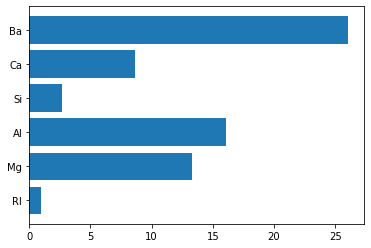

In [21]:
import matplotlib.pyplot as plt

importance = np.asarray(importance)
y_pos = np.nonzero(importance)[0]
y_value = importance[y_pos]
fig, ax = plt.subplots()
ax.barh(np.arange(y_pos.shape[0]), y_value)
ax.set_yticks(np.arange(y_pos.shape[0]))
yticklabels = np.asarray(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']) # glass
#yticklabels = y_pos # ionosphere
ax.set_yticklabels(yticklabels[y_pos])
plt.show()

## Others

In [41]:
a = np.array(
    [
        [0, 0, 0, 1, 2, 2, 0, 2],
        [1, 0, 0, 2, 2, 1, 2, 0],
        [1, 0, 0, 1, 1, 1, 1, 2]
    ]
)
b = list()
for i in range(a.shape[1]):
    u, c = np.unique(a[:,i], return_counts=True)
    b.append(u[np.argmax(c)])
print(b)

[1, 0, 0, 1, 2, 1, 0, 2]
